In [1]:
#pip install missingno

In [2]:
from fredapi import Fred
import yfinance as yf
import pandas as pd
from datetime import datetime
import missingno as msno
import matplotlib.pyplot as plt

In [3]:
FRED_API_KEY = "adf5faa6d759eb1f4b335cef60ade574"
START_DATE = "2004-11-01"
END_DATE = datetime.today().strftime("%Y-%m-%d")

fred = Fred(api_key=FRED_API_KEY)

# -----------------------------------------
# DOWNLOAD FRED MACRO DATA
# -----------------------------------------
dxy = fred.get_series("DTWEXBGS", observation_start=START_DATE)
real_yield = fred.get_series("DFII10", observation_start=START_DATE)
breakeven = fred.get_series("T10YIE", observation_start=START_DATE)
fed_funds = fred.get_series("DFF", observation_start=START_DATE)
oil = fred.get_series("DCOILWTICO", observation_start=START_DATE)

cpi = fred.get_series("CPIAUCSL", observation_start=START_DATE)
m2 = fred.get_series("M2SL", observation_start=START_DATE)

# -----------------------------------------
# TRANSFORM MONTHLY SERIES
# -----------------------------------------
cpi = cpi.resample("M").last()
m2 = m2.resample("M").last()

cpi_yoy = cpi.pct_change(12) * 100
m2_yoy = m2.pct_change(12) * 100

# Lag monthly macro to avoid look-ahead bias
cpi_yoy = cpi_yoy.shift(1)
m2_yoy = m2_yoy.shift(1)

# -----------------------------------------
# DOWNLOAD MARKET DATA (YAHOO)
# -----------------------------------------
gold = yf.download("GC=F", start=START_DATE, end=END_DATE)["Close"]
sp500 = yf.download("^GSPC", start=START_DATE, end=END_DATE)["Close"]
vix = yf.download("^VIX", start=START_DATE, end=END_DATE)["Close"]

# -----------------------------------------
# COMBINE DAILY DATA
# -----------------------------------------
daily_data = pd.concat(
    [gold, dxy, real_yield, breakeven, fed_funds, oil, sp500, vix],
    axis=1
)

daily_data.columns = [
    "Gold",
    "DXY",
    "Real_Yield_10Y",
    "Breakeven_10Y",
    "Fed_Funds",
    "WTI_Oil",
    "SP500",
    "VIX"
]

# Forward-fill macro gaps (weekends, holidays)
daily_data = daily_data.ffill()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
START_DATE = "2006-01-01"

# -----------------------------------------
# ADD MONTHLY MACRO (CPI & M2)
# -----------------------------------------
monthly_macro = pd.concat([cpi_yoy, m2_yoy], axis=1)
monthly_macro.columns = ["CPI_YoY", "M2_YoY"]

monthly_macro_daily = monthly_macro.resample("D").ffill()

last_day = gold.index[-1]
monthly_macro_daily = monthly_macro_daily.reindex(
    pd.date_range(start=monthly_macro_daily.index[0], end=last_day, freq="D")
).ffill()

# -----------------------------------------
# FINAL DATASET
# -----------------------------------------
final_data = pd.concat([daily_data, monthly_macro_daily], axis=1)
final_data = final_data.loc[START_DATE:]

final_data = final_data.bfill()

In [5]:
final_data

,Gold,DXY,Real_Yield_10Y,Breakeven_10Y,Fed_Funds,WTI_Oil,SP500,VIX,CPI_YoY,M2_YoY
2006-01-01,517.099976,101.4155,2.06,2.33,4.09,61.06,1248.290039,12.070000,3.338550,3.971091
2006-01-02,517.099976,101.4155,2.06,2.33,4.09,61.06,1248.290039,12.070000,3.338550,3.971091
2006-01-03,530.700012,100.7558,2.03,2.34,4.34,63.11,1268.800049,11.140000,3.338550,3.971091
2006-01-04,533.900024,100.2288,2.01,2.35,4.22,63.41,1273.459961,11.370000,3.338550,3.971091
2006-01-05,526.299988,100.2992,2.04,2.32,4.24,62.81,1273.479980,11.310000,3.338550,3.971091
...,...,...,...,...,...,...,...,...,...,...
2026-02-20,5059.299805,117.9917,1.80,2.28,3.64,62.53,6909.509766,19.090000,2.653304,4.230511
2026-02-21,5059.299805,117.9917,1.80,2.28,3.64,62.53,6909.509766,19.090000,2.653304,4.230511
2026-02-22,5059.299805,117.9917,1.80,2.28,3.64,62.53,6909.509766,19.090000,2.653304,4.230511
2026-02-23,5204.700195,117.9917,1.77,2.26,3.64,62.53,6837.750000,21.010000,2.653304,4.230511


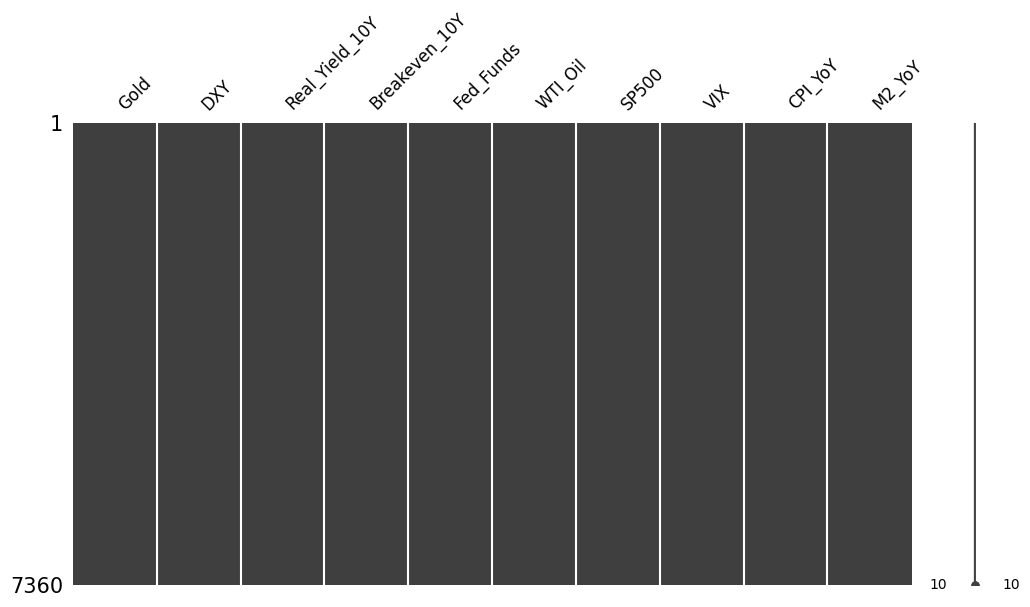

In [6]:
msno.matrix(final_data, figsize=(12, 6), fontsize=12)

# Optional: show plot
plt.show()

In [7]:
final_data.isna().sum()

Gold              0
DXY               0
Real_Yield_10Y    0
Breakeven_10Y     0
Fed_Funds         0
WTI_Oil           0
SP500             0
VIX               0
CPI_YoY           0
M2_YoY            0
dtype: int64